In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Text(0, 0.5, 'Output')

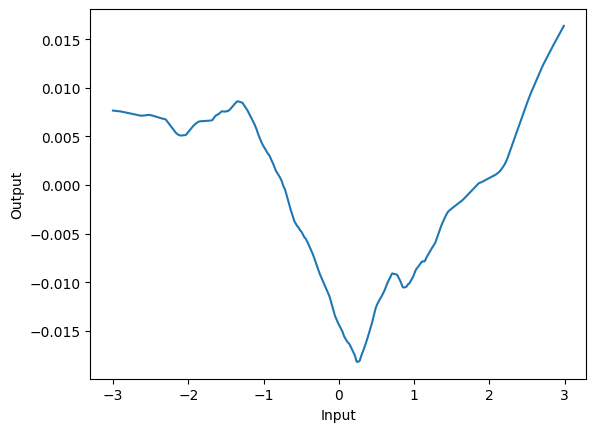

In [2]:


torch.manual_seed(0)
model = nn.Sequential(nn.Linear(1,100), nn.ReLU(), 
                      nn.Linear(100,100), nn.ReLU(), 
                      nn.Linear(100,100), nn.ReLU(), 
                      nn.Linear(100,1))
opt = optim.SGD(model.parameters(),lr=1e-2)
for _ in range(100):
    loss = nn.MSELoss()(model(torch.randn(100,1)), torch.randn(100,1))
    opt.zero_grad()
    loss.backward()
    opt.step()
                      
plt.plot(np.arange(-3,3,0.01), model(torch.arange(-3,3,0.01)[:,None]).detach().numpy())
plt.xlabel("Input")
plt.ylabel("Output")

In [3]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)    

model_dnn_2 = nn.Sequential(Flatten(), nn.Linear(784,200), nn.ReLU(), 
                            nn.Linear(200,10)).to(device)

model_dnn_4 = nn.Sequential(Flatten(), nn.Linear(784,200), nn.ReLU(), 
                            nn.Linear(200,100), nn.ReLU(),
                            nn.Linear(100,100), nn.ReLU(),
                            nn.Linear(100,10)).to(device)

model_cnn = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                          nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                          Flatten(),
                          nn.Linear(7*7*64, 100), nn.ReLU(),
                          nn.Linear(100, 10)).to(device)

In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

mnist_train = datasets.MNIST("./data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("./data", train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)

In [5]:
def epoch(loader, model, opt=None):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        yp = model(X)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [6]:
opt = optim.SGD(model_dnn_2.parameters(), lr=1e-1)
for _ in range(10):
    train_err, train_loss = epoch(train_loader, model_dnn_2, opt)
    test_err, test_loss = epoch(test_loader, model_dnn_2)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

0.132383	0.517379	0.082800	0.293092
0.075733	0.264427	0.063300	0.223535
0.059033	0.209197	0.053000	0.183850
0.048517	0.172274	0.046600	0.156987
0.041167	0.146382	0.042200	0.141074
0.035367	0.127167	0.036900	0.123752
0.031700	0.112101	0.033500	0.113114
0.027983	0.100137	0.031600	0.104723
0.024633	0.091017	0.030100	0.102954
0.023117	0.082939	0.028200	0.095694


In [7]:
opt = optim.SGD(model_dnn_4.parameters(), lr=1e-1)
for _ in range(10):
    train_err, train_loss = epoch(train_loader, model_dnn_4, opt)
    test_err, test_loss = epoch(test_loader, model_dnn_4)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

0.234417	0.779168	0.078100	0.272838
0.064633	0.218460	0.049200	0.158303
0.042350	0.142518	0.039400	0.125788
0.031383	0.106638	0.030500	0.097300
0.024317	0.084416	0.030100	0.096193
0.020183	0.067673	0.027500	0.084458
0.017250	0.056221	0.026400	0.081611
0.014267	0.046913	0.024200	0.078000
0.011433	0.039071	0.024200	0.075108
0.010017	0.033523	0.022300	0.074106


In [8]:
opt = optim.SGD(model_cnn.parameters(), lr=1e-1)
for t in range(10):
    train_err, train_loss = epoch(train_loader, model_cnn, opt)
    test_err, test_loss = epoch(test_loader, model_cnn)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

0.204300	0.606454	0.025800	0.084089
0.024683	0.079391	0.017400	0.055094
0.017250	0.054505	0.016100	0.050906
0.013033	0.040433	0.014800	0.047627
0.009333	0.029688	0.011300	0.035705
0.004150	0.013771	0.009800	0.031140
0.002933	0.010831	0.010400	0.031868
0.002317	0.009553	0.009500	0.031900
0.002117	0.008619	0.010200	0.032619
0.001817	0.007784	0.010500	0.033737


In [9]:
torch.save(model_dnn_2.state_dict(), "model_dnn_2.pt")
torch.save(model_dnn_4.state_dict(), "model_dnn_4.pt")
torch.save(model_cnn.state_dict(), "model_cnn.pt")

In [10]:
model_dnn_2.load_state_dict(torch.load("model_dnn_2.pt"))
model_dnn_4.load_state_dict(torch.load("model_dnn_4.pt"))
model_cnn.load_state_dict(torch.load("model_cnn.pt"))

/tmp/ipykernel_183505/811293303.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dnn_2.load_state_dict(torch.load("model_dnn_2.pt"))
/tmp/ipykernel_183505/811293303

<All keys matched successfully>

In [11]:
def fgsm(model, X, y, epsilon):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

In [12]:
for X,y in test_loader:
    X,y = X.to(device), y.to(device)
    break
    
def plot_images(X,y,yp,M,N):
    f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(N,M*1.3))
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(1-X[i*N+j][0].cpu().numpy(), cmap="gray")
            title = ax[i][j].set_title("Pred: {}".format(yp[i*N+j].max(dim=0)[1]))
            plt.setp(title, color=('g' if yp[i*N+j].max(dim=0)[1] == y[i*N+j] else 'r'))
            ax[i][j].set_axis_off()
    plt.tight_layout()

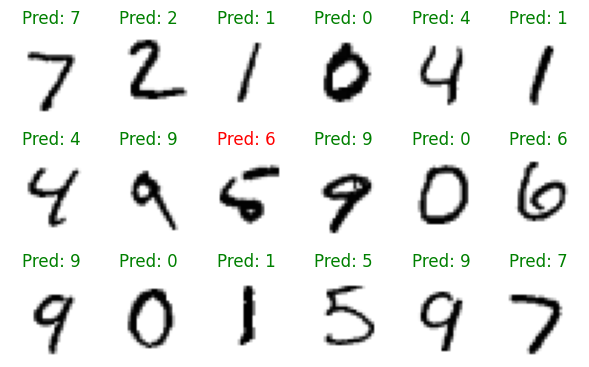

In [13]:
### Illustrate original predictions
yp = model_dnn_2(X)
plot_images(X, y, yp, 3, 6)

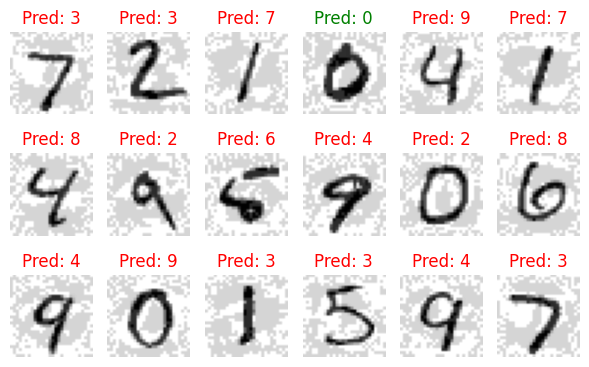

In [14]:

### Illustrate attacked images
delta = fgsm(model_dnn_2, X, y, 0.1)
yp = model_dnn_2(X + delta)
plot_images(X+delta, y, yp, 3, 6)

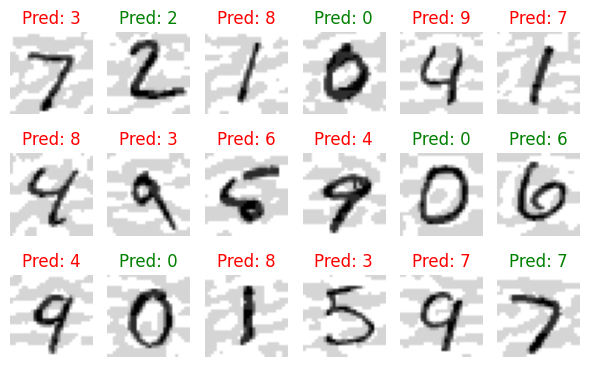

In [15]:
### Illustrate attacked images
delta = fgsm(model_cnn, X, y, 0.1)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

In [16]:
def epoch_adversarial(model, loader, attack, *args):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        delta = attack(model, X, y, *args)
        yp = model(X+delta)
        loss = nn.CrossEntropyLoss()(yp,y)
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [17]:
print("2-layer DNN:", epoch_adversarial(model_dnn_2, test_loader, fgsm, 0.1)[0])
print("4-layer DNN:", epoch_adversarial(model_dnn_4, test_loader, fgsm, 0.1)[0])
print("        CNN:", epoch_adversarial(model_cnn, test_loader, fgsm, 0.1)[0])

2-layer DNN: 0.9128
4-layer DNN: 0.934
        CNN: 0.4577


In [18]:
def pgd(model, X, y, epsilon, alpha, num_iter):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + X.shape[0]*alpha*delta.grad.data).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

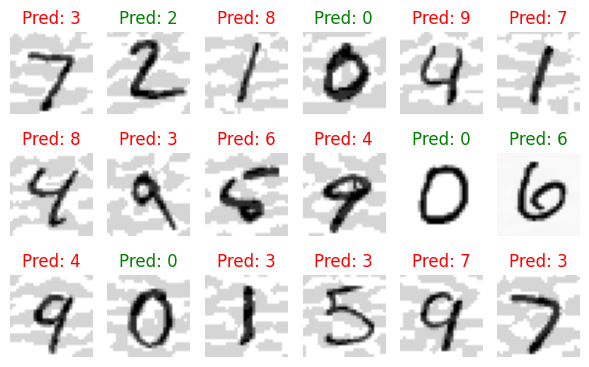

In [19]:
### Illustrate attacked images
delta = pgd(model_cnn, X, y, 0.1, 1e4, 1000)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

In [20]:
delta = torch.zeros_like(X, requires_grad=True)
loss = nn.CrossEntropyLoss()(model_cnn(X + delta), y)
loss.backward()
print(delta.grad.abs().mean().item())

5.2400396270968486e-06


In [21]:
def pgd_linf(model, X, y, epsilon, alpha, num_iter):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

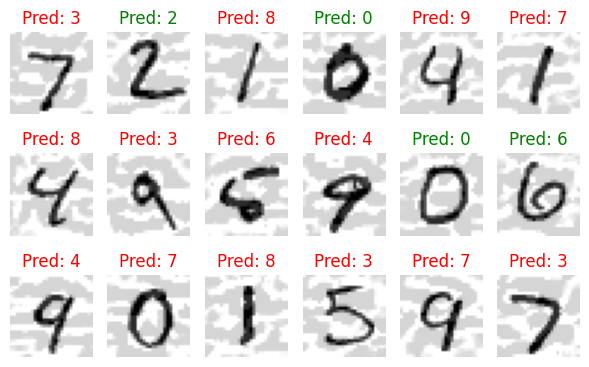

In [22]:
### Illustrate attacked images
delta = pgd_linf(model_cnn, X, y, epsilon=0.1, alpha=1e-2, num_iter=40)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

In [23]:
print("2-layer DNN:", epoch_adversarial(model_dnn_2, test_loader, pgd_linf, 0.1, 1e-2, 40)[0])
print("4-layer DNN:", epoch_adversarial(model_dnn_4, test_loader, pgd_linf, 0.1, 1e-2, 40)[0])
print("CNN:", epoch_adversarial(model_cnn, test_loader, pgd_linf, 0.1, 1e-2, 40)[0])

2-layer DNN: 0.9557
4-layer DNN: 0.9907
CNN: 0.7325


In [24]:
def pgd_linf_rand(model, X, y, epsilon, alpha, num_iter, restarts):
    """ Construct PGD adversarial examples on the samples X, with random restarts"""
    max_loss = torch.zeros(y.shape[0]).to(y.device)
    max_delta = torch.zeros_like(X)
    
    for i in range(restarts):
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
        
        for t in range(num_iter):
            loss = nn.CrossEntropyLoss()(model(X + delta), y)
            loss.backward()
            delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
            delta.grad.zero_()
        
        all_loss = nn.CrossEntropyLoss(reduction='none')(model(X+delta),y)
        max_delta[all_loss >= max_loss] = delta.detach()[all_loss >= max_loss]
        max_loss = torch.max(max_loss, all_loss)
        
    return max_delta

In [25]:
print("CNN:", epoch_adversarial(model_cnn, test_loader, pgd_linf_rand, 0.1, 1e-2, 40, 10)[0])

CNN: 0.7532


In [26]:
def pgd_linf_targ(model, X, y, epsilon, alpha, num_iter, y_targ):
    """ Construct targeted adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        yp = model(X + delta)
        loss = (yp[:,y_targ] - yp.gather(1,y[:,None])[:,0]).sum()
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

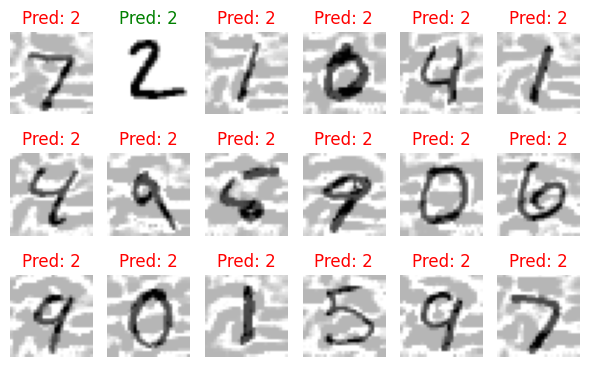

In [27]:
delta = pgd_linf_targ(model_cnn, X, y, epsilon=0.2, alpha=1e-2, num_iter=40, y_targ=2)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

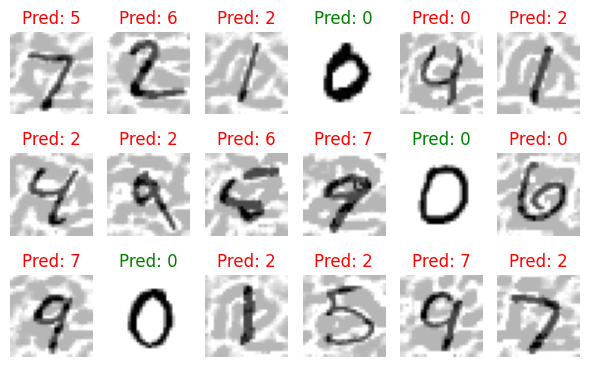

In [28]:
delta = pgd_linf_targ(model_cnn, X, y, epsilon=0.2, alpha=1e-2, num_iter=40, y_targ=0)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

In [29]:
def pgd_linf_targ2(model, X, y, epsilon, alpha, num_iter, y_targ):
    """ Construct targeted adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        yp = model(X + delta)
        loss = 2*yp[:,y_targ].sum() - yp.sum()
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

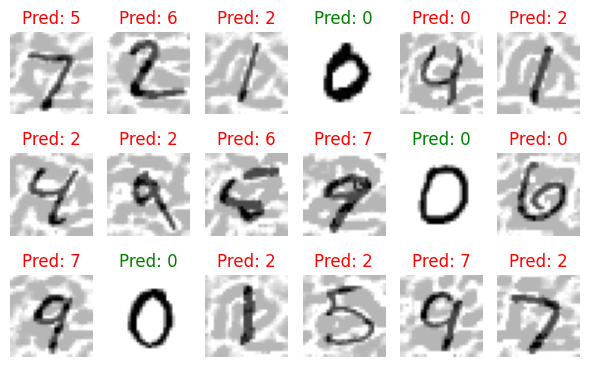

In [30]:
delta = pgd_linf_targ(model_cnn, X, y, epsilon=0.2, alpha=1e-2, num_iter=40, y_targ=0)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

In [31]:
def norms(Z):
    """Compute norms over all but the first dimension"""
    return Z.view(Z.shape[0], -1).norm(dim=1)[:,None,None,None]


def pgd_l2(model, X, y, epsilon, alpha, num_iter):
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data += alpha*delta.grad.detach() / norms(delta.grad.detach())
        delta.data = torch.min(torch.max(delta.detach(), -X), 1-X) # clip X+delta to [0,1]
        delta.data *= epsilon / norms(delta.detach()).clamp(min=epsilon)
        delta.grad.zero_()
        
    return delta.detach()

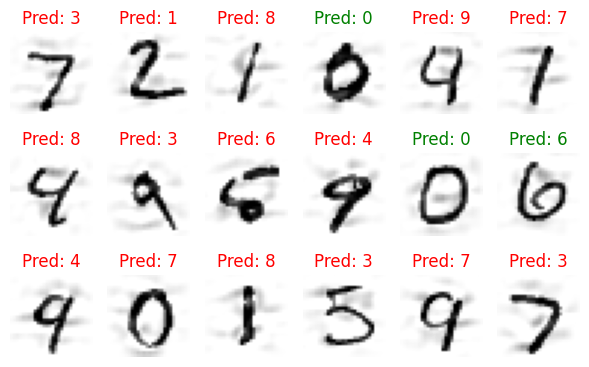

In [32]:
delta = pgd_l2(model_cnn, X, y, epsilon=2, alpha=0.1, num_iter=40)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

In [33]:
print("2-layer DNN:", epoch_adversarial(model_dnn_2, test_loader, pgd_l2, 2, 0.1, 40)[0])
print("4-layer DNN:", epoch_adversarial(model_dnn_4, test_loader, pgd_l2, 2, 0.1, 40)[0])
print("CNN:", epoch_adversarial(model_cnn, test_loader, pgd_l2, 2, 0.1, 40)[0])

2-layer DNN: 0.912
4-layer DNN: 0.9577
CNN: 0.795


In [34]:
def bound_propagation(model, initial_bound):
    l, u = initial_bound
    bounds = []
    
    for layer in model:
        if isinstance(layer, Flatten):
            l_ = Flatten()(l)
            u_ = Flatten()(u)
        elif isinstance(layer, nn.Linear):
            l_ = (layer.weight.clamp(min=0) @ l.t() + layer.weight.clamp(max=0) @ u.t() 
                  + layer.bias[:,None]).t()
            u_ = (layer.weight.clamp(min=0) @ u.t() + layer.weight.clamp(max=0) @ l.t() 
                  + layer.bias[:,None]).t()
        elif isinstance(layer, nn.Conv2d):
            l_ = (nn.functional.conv2d(l, layer.weight.clamp(min=0), bias=None, 
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  nn.functional.conv2d(u, layer.weight.clamp(max=0), bias=None, 
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  layer.bias[None,:,None,None])
            
            u_ = (nn.functional.conv2d(u, layer.weight.clamp(min=0), bias=None, 
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  nn.functional.conv2d(l, layer.weight.clamp(max=0), bias=None, 
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) + 
                  layer.bias[None,:,None,None])
            
        elif isinstance(layer, nn.ReLU):
            l_ = l.clamp(min=0)
            u_ = u.clamp(min=0)
            
        bounds.append((l_, u_))
        l,u = l_, u_
    return bounds

In [35]:
epsilon = 0.1
bounds = bound_propagation(model_cnn, ((X - epsilon).clamp(min=0), (X + epsilon).clamp(max=1)))
print("lower bound: ", bounds[-1][0][0].detach().cpu().numpy())
print("upper bound: ", bounds[-1][1][0].detach().cpu().numpy())

lower bound:  [-2855.4631 -2571.039  -3696.8293 -2543.9111 -2867.7935 -2444.5105
 -2912.023  -2475.7058 -2545.2742 -2578.3105]
upper bound:  [2186.5938 2673.1711 2457.4033 2726.826  2844.7742 3080.524  2242.0413
 3211.849  3151.519  2782.5747]


In [36]:
epsilon = 0.1
bounds = bound_propagation(model_dnn_2, ((X - epsilon).clamp(min=0), (X + epsilon).clamp(max=1)))
print("lower bound: ", bounds[-1][0][0].detach().cpu().numpy())
print("upper bound: ", bounds[-1][1][0].detach().cpu().numpy())

lower bound:  [-20.560423 -23.64547  -17.535437 -16.681828 -32.128284 -22.724869
 -30.491901 -15.737773 -23.58483  -25.076939]
upper bound:  [19.24827  14.374581 25.719341 29.486425 18.704813 28.60849  11.866371
 32.1335   23.711868 25.589342]


In [37]:
epsilon = 0.1
bounds = bound_propagation(model_dnn_4, ((X - epsilon).clamp(min=0), (X + epsilon).clamp(max=1)))
print("lower bound: ", bounds[-1][0][0].detach().cpu().numpy())
print("upper bound: ", bounds[-1][1][0].detach().cpu().numpy())

lower bound:  [-220.44913 -206.34962 -187.77368 -221.78787 -233.58583 -179.13441
 -244.60938 -202.73329 -207.64474 -204.78436]
upper bound:  [192.9366  211.39684 180.75684 212.42493 194.95622 216.43507 192.93724
 239.62477 209.22014 220.56755]


In [38]:
import cvxpy as cp

def form_milp(model, c, initial_bounds, bounds):
    linear_layers = [(layer, bound) for layer, bound in zip(model,bounds) if isinstance(layer, nn.Linear)]
    d = len(linear_layers)-1
    
    # create cvxpy variables
    z = ([cp.Variable(layer.in_features) for layer, _ in linear_layers] + 
         [cp.Variable(linear_layers[-1][0].out_features)])
    v = [cp.Variable(layer.out_features, boolean=True) for layer, _ in linear_layers[:-1]]
    
    # extract relevant matrices
    W = [layer.weight.detach().cpu().numpy() for layer,_ in linear_layers]
    b = [layer.bias.detach().cpu().numpy() for layer,_ in linear_layers]
    l = [l[0].detach().cpu().numpy() for _, (l,_) in linear_layers]
    u = [u[0].detach().cpu().numpy() for _, (_,u) in linear_layers]
    l0 = initial_bound[0][0].view(-1).detach().cpu().numpy()
    u0 = initial_bound[1][0].view(-1).detach().cpu().numpy()
    
    # add ReLU constraints
    constraints = []
    for i in range(len(linear_layers)-1):
        constraints += [z[i+1] >= W[i] @ z[i] + b[i], 
                        z[i+1] >= 0,
                        cp.multiply(v[i], u[i]) >= z[i+1],
                        W[i] @ z[i] + b[i] >= z[i+1] + cp.multiply((1-v[i]), l[i])]
    
    # final linear constraint
    constraints += [z[d+1] == W[d] @ z[d] + b[d]]
    
    # initial bound constraints
    constraints += [z[0] >= l0, z[0] <= u0]
    
    return cp.Problem(cp.Minimize(c @ z[d+1]), constraints), (z, v)

In [39]:
model_small = nn.Sequential(Flatten(), nn.Linear(784,50), nn.ReLU(), 
                            nn.Linear(50,20), nn.ReLU(), 
                            nn.Linear(20,10)).to(device)

In [40]:
# train model and save to disk
opt = optim.SGD(model_small.parameters(), lr=1e-1)
for _ in range(10):
    train_err, train_loss = epoch(train_loader, model_small, opt)
    test_err, test_loss = epoch(test_loader, model_small)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")
torch.save(model_small.state_dict(), "model_small.pt")

0.217417	0.696471	0.092200	0.311858
0.079217	0.271803	0.064200	0.214817
0.057433	0.195419	0.049800	0.161164
0.045467	0.154868	0.043500	0.142079
0.038000	0.127819	0.038100	0.124362
0.032833	0.109174	0.034000	0.107887
0.028600	0.095284	0.032400	0.103150
0.025233	0.085190	0.032000	0.106021
0.023100	0.075667	0.029200	0.092511
0.020433	0.069079	0.031100	0.105078


In [41]:
# load model from disk
model_small.load_state_dict(torch.load("model_small.pt"))

/tmp/ipykernel_183505/3693529935.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_small.load_state_dict(torch.load("model_small.pt"))


<All keys matched successfully>

In [42]:
initial_bound = ((X[0:1] - epsilon).clamp(min=0), (X[0:1] + epsilon).clamp(max=1))
bounds = bound_propagation(model_small, initial_bound)
c = np.zeros(10)
c[y[0].item()] = 1
c[2] = -1

prob, (z, v) = form_milp(model_small, c, initial_bound, bounds)

In [43]:
prob.solve(solver=cp.GUROBI, verbose=True)

                                     CVXPY                                     
                                     v1.5.2                                    
(CVXPY) Apr 12 06:26:38 PM: Your problem has 934 variables, 1858 constraints, and 0 parameters.
(CVXPY) Apr 12 06:26:38 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 12 06:26:38 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 12 06:26:38 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 12 06:26:38 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 12 06:26:38 PM: Compiling problem (target solver=GUROBI)

-3.225911939123418

In [44]:
print("Last layer values from MILP:", z[3].value)

Last layer values from MILP: [  2.81749204  -3.06013756  10.23443485   8.36046736 -10.22004589
   0.21691574 -11.73774244   7.00852291   4.7999847   -3.26642365]


In [45]:
print("Last layer from model:", 
      model_small(torch.tensor(z[0].value).float().view(1,1,28,28).to(device))[0].detach().cpu().numpy())

Last layer from model: [  2.817492    -3.0601382   10.234435     8.360467   -10.220047
   0.21691571 -11.737741     7.008521     4.799986    -3.266424  ]


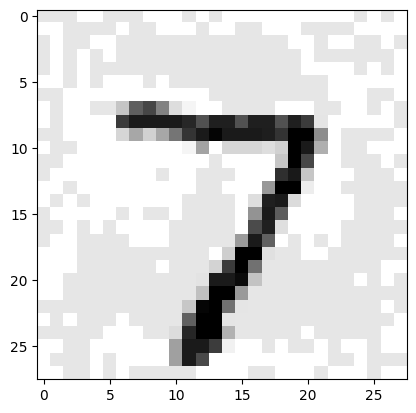

In [46]:
plt.imshow(1-z[0].value.reshape(28,28), cmap="gray")

In [47]:
epsilon = 0.05
initial_bound = ((X[0:1] - epsilon).clamp(min=0), (X[0:1] + epsilon).clamp(max=1))
bounds = bound_propagation(model_small, initial_bound)

for y_targ in range(10):
    if y_targ != y[0].item():
        c = np.eye(10)[y[0].item()] - np.eye(10)[y_targ]
        prob, _ = form_milp(model_small, c, initial_bound, bounds)
        print("Targeted attack {} objective: {}".format(y_targ, prob.solve(solver=cp.GUROBI)))

Targeted attack 0 objective: 8.084621471168452
Targeted attack 1 objective: 12.975467614889116
Targeted attack 2 objective: 3.16368559925143
Targeted attack 3 objective: 2.4411197523280723
Targeted attack 4 objective: 11.65788101861424
Targeted attack 5 objective: 9.064827362176294
Targeted attack 6 objective: 22.402332700312176
Targeted attack 8 objective: 4.976967701637535
Targeted attack 9 objective: 6.069808212270474


In [48]:
epsilon = 0.1
initial_bound = ((X[0:1] - epsilon).clamp(min=0), (X[0:1] + epsilon).clamp(max=1))
bounds = bound_propagation(model_small, initial_bound)

for y_targ in range(10):
    if y_targ != y[0].item():
        c = np.eye(10)[y[0].item()] - np.eye(10)[y_targ]
        prob, _ = form_milp(model_small, c, initial_bound, bounds)
        print("Targeted attack {} objective: {}".format(y_targ, prob.solve(solver=cp.GUROBI)))

Targeted attack 0 objective: 0.774900466111629
Targeted attack 1 objective: 6.26327381581288
Targeted attack 2 objective: -3.225911939123418
Targeted attack 3 objective: -4.818509852618486
Targeted attack 4 objective: 5.186564397880513
Targeted attack 5 objective: 1.9734883186947645
Targeted attack 6 objective: 13.013704428222562
Targeted attack 8 objective: -2.256757870740434
Targeted attack 9 objective: 0.1290756386361407


In [49]:
def form_lp(model, c, initial_bounds, bounds):
    linear_layers = [(layer, bound) for layer, bound in zip(model,bounds) if isinstance(layer, nn.Linear)]
    d = len(linear_layers)-1
    
    # create cvxpy variables
    z = ([cp.Variable(layer.in_features) for layer, _ in linear_layers] + 
         [cp.Variable(linear_layers[-1][0].out_features)])
    v = [cp.Variable(layer.out_features) for layer, _ in linear_layers[:-1]]
    
    # extract relevant matrices
    W = [layer.weight.detach().cpu().numpy() for layer,_ in linear_layers]
    b = [layer.bias.detach().cpu().numpy() for layer,_ in linear_layers]
    l = [l[0].detach().cpu().numpy() for _, (l,_) in linear_layers]
    u = [u[0].detach().cpu().numpy() for _, (_,u) in linear_layers]
    l0 = initial_bound[0][0].view(-1).detach().cpu().numpy()
    u0 = initial_bound[1][0].view(-1).detach().cpu().numpy()
    
    # add ReLU constraints
    constraints = []
    for i in range(len(linear_layers)-1):
        constraints += [z[i+1] >= W[i] @ z[i] + b[i], 
                        z[i+1] >= 0,
                        cp.multiply(v[i], u[i]) >= z[i+1],
                        W[i] @ z[i] + b[i] >= z[i+1] + cp.multiply((1-v[i]), l[i]),
                        v[i] >= 0,
                        v[i] <= 1]
    
    # final linear constraint
    constraints += [z[d+1] == W[d] @ z[d] + b[d]]
    
    # initial bound constraints
    constraints += [z[0] >= l0, z[0] <= u0]
    
    return cp.Problem(cp.Minimize(c @ z[d+1]), constraints), (z, v)

In [51]:
initial_bound = ((X[0:1] - epsilon).clamp(min=0), (X[0:1] + epsilon).clamp(max=1))
bounds = bound_propagation(model_small, initial_bound)
c = np.eye(10)[y[0].item()] - np.eye(10)[2]

prob, (z, v) = form_lp(model_small, c, initial_bound, bounds)
print("Objective value:", prob.solve(solver=cp.GUROBI))
print("Last layer from relaxation:", z[3].value)

Objective value: -30.445467280811798
Last layer from relaxation: [ 10.61930755  -8.00783511  24.99608703   7.27186848 -14.09313748
   0.36844093   0.42339702  -5.44938025   6.15953599 -12.38435955]


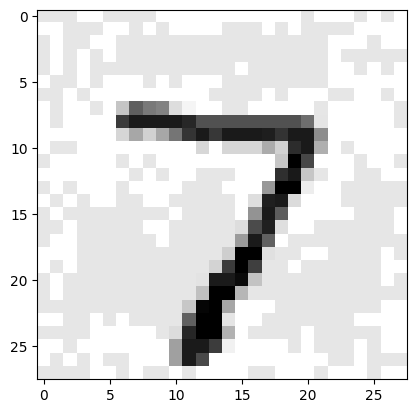

In [52]:
plt.imshow(1-z[0].value.reshape(28,28), cmap="gray")

In [53]:
print("Last layer from model:", 
      model_small(torch.tensor(z[0].value).float().view(1,1,28,28).to(device))[0].detach().cpu().numpy())

Last layer from model: [ 1.7471993  -2.5636814   8.261734    6.485653   -7.659953   -0.41698933
 -9.980528    6.367086    4.2566605  -2.2540815 ]


In [60]:
epsilon = 0.02
initial_bound = ((X[0:1] - epsilon).clamp(min=0), (X[0:1] + epsilon).clamp(max=1))
bounds = bound_propagation(model_small, initial_bound)

for y_targ in range(10):
    if y_targ != y[0].item():
        c = np.eye(10)[y[0].item()] - np.eye(10)[y_targ]
        prob, _ = form_lp(model_small, c, initial_bound, bounds)
        print("Targeted attack {} objective: {}".format(y_targ, prob.solve(solver=cp.GUROBI)))

Targeted attack 0 objective: 9.18712567594846
Targeted attack 1 objective: 14.61376613199486
Targeted attack 2 objective: 4.746316607451355
Targeted attack 3 objective: 3.8486686291440293
Targeted attack 4 objective: 14.239985579120846
Targeted attack 5 objective: 9.830999959024231
Targeted attack 6 objective: 23.256838783453667
Targeted attack 8 objective: 7.258987973138355
Targeted attack 9 objective: 7.865875866040316


In [63]:
epsilon = 0.01
initial_bound = ((X[0:1] - epsilon).clamp(min=0), (X[0:1] + epsilon).clamp(max=1))
bounds = bound_propagation(model_dnn_4, initial_bound)

for y_targ in range(10):
    if y_targ != y[0].item():
        c = np.eye(10)[y[0].item()] - np.eye(10)[y_targ]
        prob, _ = form_lp(model_dnn_4, c, initial_bound, bounds)
        print("Targeted attack {} objective: {}".format(y_targ, prob.solve(solver=cp.ECOS)))

Targeted attack 0 objective: 4.9517729787365194
Targeted attack 1 objective: 3.874218213776362
Targeted attack 2 objective: 1.6757972500063651
Targeted attack 3 objective: -2.2969073548126184
Targeted attack 4 objective: 12.951596991011728
Targeted attack 5 objective: 0.140134351077827
Targeted attack 6 objective: 13.050637176316002
Targeted attack 8 objective: -1.4000302652154044
Targeted attack 9 objective: -2.093556869235737


In [64]:
def interval_based_bound(model, c, bounds):
    # requires last layer to be linear
    cW = c.t() @ model[-1].weight
    cb = c.t() @ model[-1].bias
    l,u = bounds[-2]
    return (cW.clamp(min=0) @ l.t() + cW.clamp(max=0) @ u.t() + cb[:,None]).t()  

In [65]:
epsilon = 0.02
initial_bound = ((X[0:1] - epsilon).clamp(min=0), (X[0:1] + epsilon).clamp(max=1))
bounds = bound_propagation(model_small, initial_bound)
C = -torch.eye(10).to(device)
C[y[0].item(),:] += 1

print(interval_based_bound(model_small, C, bounds).detach().cpu().numpy())

[[-5.2146845  0.9834416 -8.95515   -9.430425  -1.6530738 -5.675324
   6.744165   0.        -9.852957  -7.0858884]]
